# Reinforcement Learning: An Introduction; Richard S. Sutton and Andrew G. Barto

## Monte Carlo (MC) on-policy RL

### In contrast to DP methods, MC methods are suitable when the model of the environment is unknown
### The MC methods uses the experiance of an agent to learn the optimal policy without accesing the model of the environment (State transitions probabilities / underlying Markov model)
### MC methods require terminated episode in order to estimate the value function for a given policy; Experiance of the agent
### DP does not wait till the episode ends since the agent has the access to the model; Only one step transition is considered
### In DP there is no learning (of the value function) happening, since the model is available

### In MC we consider the return agent recieves at a perticular state



In [1]:
## Mout your google drive
from google.colab import drive
## mount location
drive.mount('/content/drive')

Mounted at /content/drive


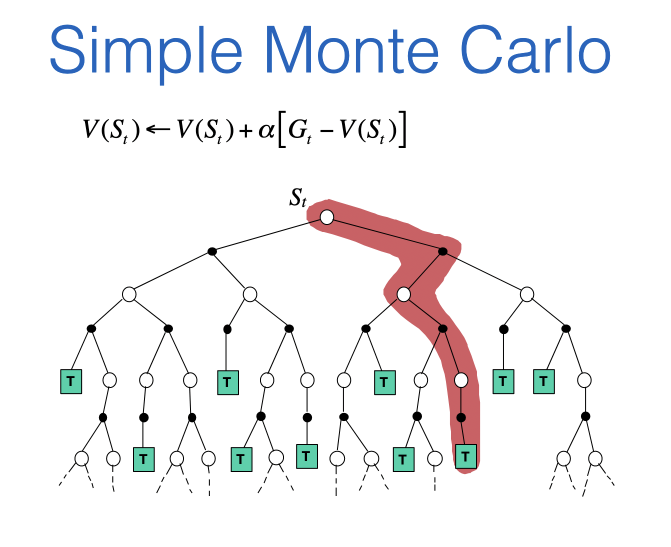

In [6]:
## https://web.stanford.edu/class/cme241/lecture_slides/rich_sutton_slides/11-12-TD.pdf
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread("/content/drive/MyDrive/rl/mc.png", cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (img.shape[1] // 2, img.shape[0] // 2), cv2.INTER_CUBIC)
cv2_imshow(img)

### We average the return for a given state and assume that when more and more times the return is averaged, the average should converge to the expected value of the return for that state (law of large numbers)
### Formalism:
### Given a policy $\pi$, when the agent follows this policy several times (episode) the agent can visit a perticular state s several times (throught the episodes)
### When the agent step to the state s, it is called a visit to that state
### The agent can visit the state s several times in a single episode and based on that there are two MC methods
### &emsp;&emsp; First visit MC
### &emsp;&emsp; Every vist MC

### In first visit MC, we simply take the return from the first time the agent visit that state in a given episode
### For a given episode in multi visit MC, we take the return of the state s, each time the agent visits that state




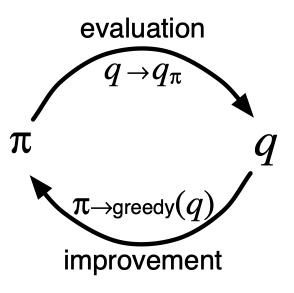

In [7]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread("/content/drive/MyDrive/rl/gpi.png", cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (img.shape[1] // 2, img.shape[0] // 2), cv2.INTER_CUBIC)
cv2_imshow(img)

### Following is the Algorithm for MC prediction step (equivalent to policy evaluation)
### Algorithm (First-Visit MC):
### Initialise
### &emsp;&emsp; $\pi$ a policy to be evaluated
### &emsp;&emsp; $V$ an arbitrary state-value function
### &emsp;&emsp; Returns(s) an empty list to hold the returns for a state s when the agent visit that state; for all $s \in S$

### Repeat forever:
### &emsp;&emsp; Generate an episode using $\pi$
### &emsp;&emsp; For each state s appearing in the episode:
### &emsp;&emsp; G = return following the first occurance of s
### &emsp;&emsp; Append G to Returns(s)
### &emsp;&emsp; V(s) = average(Returns(s))

### Next step is the MC control (equivalent to policy improvement)
### this is done by taking greedy actions ($argmax_{a}$) w.r.t the current policy $\pi$

In [2]:
## https://github.com/nric/MonteCarloFrozenLake/blob/master/monte_carlo_gym_frozenlake.py
""" 
This is a monte carlo controll first visit solution to discrete toy text open ai gym enviroment FrozenLake-v0. 
Theoretically, it should be able to solve all toy text enviroments but here it is tested for Frozen Lake.
It is written using visual studio code with Jupyter Kernel connection (Python interactive). 
Just run the cell. If you want to run using python interpreter directly, replace def main(): to if name == 'main': and remove the last line (call of main()).
"""
import gym
import numpy as np
from itertools import product


def epsilon_action(a,env,epsilon = 0.1):
    """ 
    Return the action most of the time but in 1-epsiolon of the cases a random action within the env.env.action_space is returned
    Return: action
    """
    rand_number = np.random.random()
    if rand_number < (1-epsilon):
        return a
    else:
        return env.action_space.sample()

def play_a_game(env,policy,epsilon=0.1):
    """ 
    Returns the lived S,A,R of an episode (as a list of a list). In monte carlo the path is epsion-greed partly random.
    Args: env: Gym enviroment policy: the current policy
    Return: List of all states with S,A,R for each.
    """
    env.reset()
    finished = False
    episode_sar = []
    while not finished:
        current_s= env.env.s
        action = epsilon_action(policy[current_s],env,epsilon=epsilon)
        new_s, reward, finished, _info =  env.step(action)
        episode_sar.append([current_s,action,reward])
    #episode_sar.append([new_s,None,reward])
    return episode_sar

def sar_to_sag(sar_list,GAMMA=0.9):
    """ 
    The gain G in Monte Carlo is caluclates by means of the reward for each state and a discount factor Gamma for earlier episondes.
    Careful: SAR list needs to be reversed for correct calculation of G
    Args: sar_list: List of S,A,R values of this episode. Gamma: discount factor for future episodes
    Return: List of all states with S,A,G for each state visited.
    """
    G = 0
    state_action_gain = []
    for s,a,r in reversed(sar_list):
        G = r + GAMMA*G
        state_action_gain.append([s,a,G])
    return reversed(state_action_gain)


def monte_carlo(env, episodes=10000, epsilon=0.1):
    """ 
    Function for generating a policy the monte carlo way: Play a lot, find the optimal policy this way
    Args: env: the open ai gym enviroment object
    Return: policy: the "optimal" policy V: the value table for each s (optional)
    """
    #create a random policy
    policy = {j:np.random.choice(env.action_space.n) for j in range(env.observation_space.n)} 
    #Gain or return is cummulative rewards over the entiere episode g(t) = r(t+1) + gamma*G(t+1)
    G = 0
    #Q function is essential for the policy update
    Q = {j:{i:0 for i in range(env.action_space.n)} for j in range(env.observation_space.n)} 
    #The s,a pairs of the Q function are updated using mean of returns of each episode. So returns need to be collected
    returns = {(s,a):[] for s,a in product(range(env.observation_space.n),range(env.action_space.n))}

    for ii in range(episodes):
        seen_state_action_pairs = set()
        #play a game and convert S,A,R to S,A,G
        episode_sag = sar_to_sag(play_a_game(env,policy,epsilon=epsilon if ii > 1000 else 1))        
        #Use S,A,G to update Q (first-visit method), retruns and seen_state_action_paris
        for s,a,G in episode_sag:
            sa = (s, a)
            if sa not in seen_state_action_pairs:
                returns[sa].append(G)
                Q[s][a] = np.mean(returns[sa])
                seen_state_action_pairs.add(sa)
        # calculate new policy p[s] = argmax[a]{Q(s,a)}
        for s in policy.keys():
            policy[s] = max(Q[s],key=Q[s].get)

    #optional: create V[s]
    V = {s:max(list(Q[s].values())) for s in policy.keys()}

    return policy, V

def test_policy(env,policy):
    env.reset()
    finished = False
    while not finished:
        _new_s, _reward, finished, _info =  env.step(policy[env.env.s])
        env.render()
        if finished: break

def main():
    #env = gym.make('FrozenLake8x8-v0')
    env = gym.make('FrozenLake-v0')
    env.render()
    policy, V = monte_carlo(env,episodes=10000,epsilon=0.1)   
    print(policy)
    test_policy(env,policy)

main()


SFFF
FHFH
FFFH
HFFG
{0: 0, 1: 3, 2: 0, 3: 1, 4: 1, 5: 0, 6: 2, 7: 0, 8: 3, 9: 1, 10: 1, 11: 0, 12: 0, 13: 2, 14: 1, 15: 0}
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
